pyDPVis is a Python tool to visualize the structure of SAT instances and runs of the DPLL (Davis-Putnam-Logemann-Loveland) procedure. 

It uses networkx to display the problem's internal structure arising from its variable dependency graph. 

It can also generate animations showing dynamic change in structure during a DPLL algorithm run (wip).

This codebase includes a simplified DPLL in Python. Planning to add MiniSAT soon, as well as ability to visualize the search tree and clause learning.

I made this tool as an alternative to DPVis for teaching the DPLL algorithm, and for forming an intuitive sense between structure and hardness of SAT instances.

Daniel A. Espinosa Gonzalez 2024, Strukov Group at UC Santa Barbara
Work in progress ; Need to add faster visualization of very large SAT problems + better visualization of DPLL step by step

Nodes:
Each unique literal in the CNF formula is represented by a node.
The number of nodes is equal to the number of literals specified in the CNF file.
Nodes are numbered from 1 to N, where N is the total number of literals.
Edges:
An edge is created between two nodes if their corresponding literals appear in the same clause, regardless of their polarity (positive or negative). Multiple occurrences of two literals in different clauses still result in only one edge between their nodes (this is to not fry my laptop).


In [1]:
import graphmaker as gp
filename = "mnci_n96_t3_1_3sat.cnf"

pos, edges, num_vars = gp.make_graph_positions_optimized(filename)
gp.plot_graph_from_positions(pos, edges, num_vars)

Parsing Dimacs File: 7674it [00:00, 403731.48it/s]


Variables: 3046, Clauses: 7673


Generating graph: 100%|██████████| 7673/7673 [00:00<00:00, 108078.98it/s]


Calculating layout...
Preparing edge data...


Parsing Dimacs File: 7674it [00:00, 319811.30it/s]
Generating graph: 100%|██████████| 7673/7673 [00:00<00:00, 159865.75it/s]


Calculating layout...
Preparing edge data...
Graph saved as 'cnf_graph_2d.png'


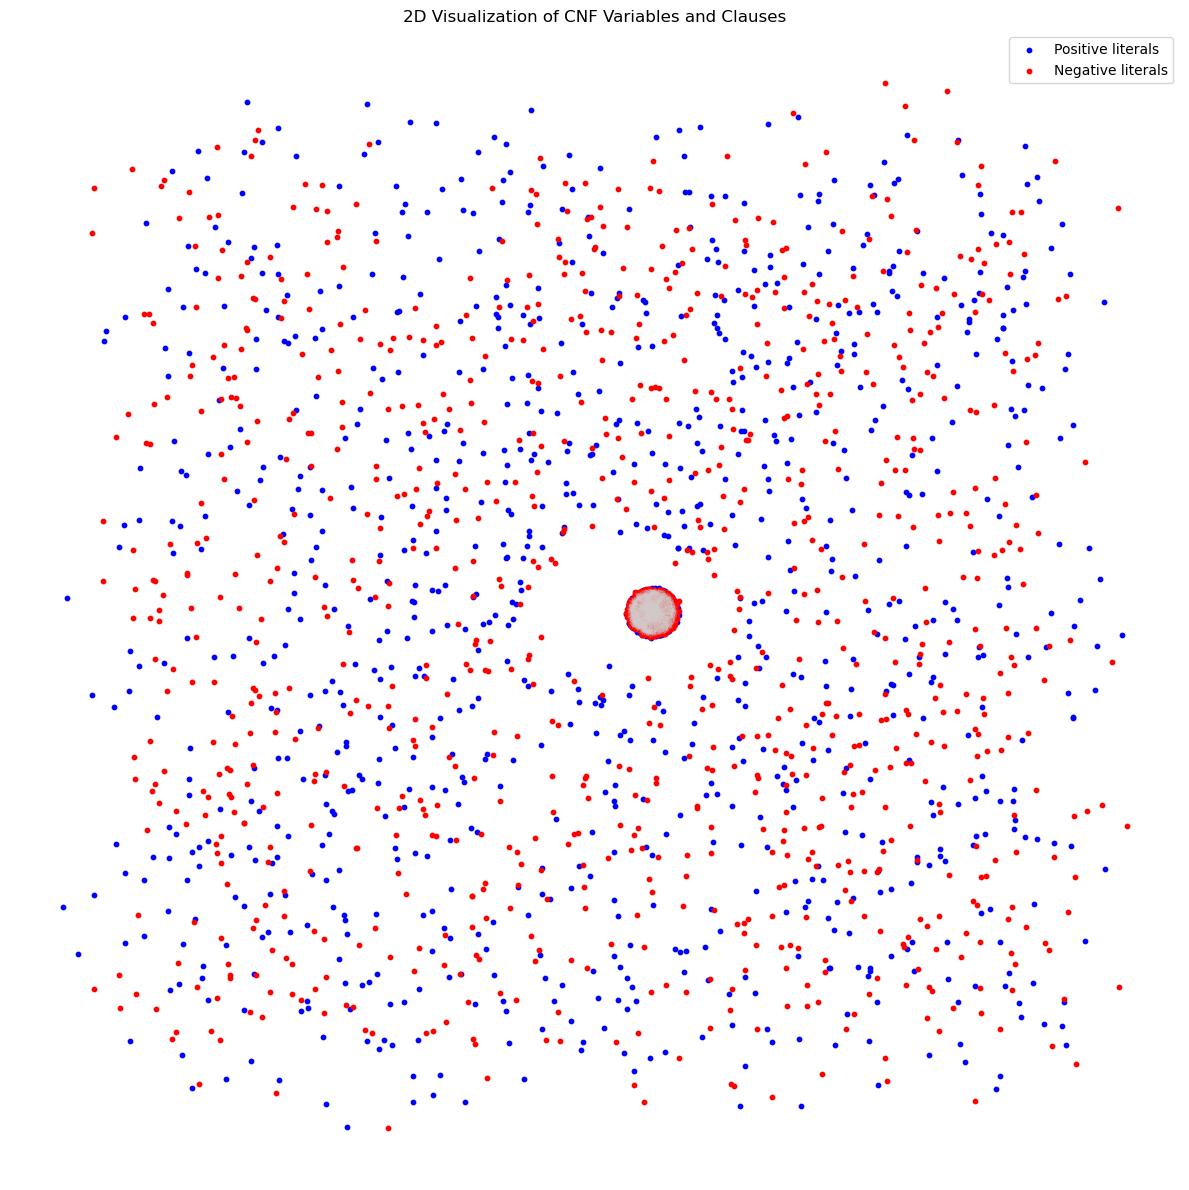

In [2]:
import numpy as np
import igraph as ig
from tqdm import tqdm
import rdimacs as rd
import matplotlib.pyplot as plt

def make_2d_graph(filename, max_edges=10000):
    num_vars, clauses = rd.read_dimacs(filename)
    G = generate_interaction_graph_optimized(num_vars, clauses)
   
    print("Calculating layout...")
    pos = G.layout_fruchterman_reingold(dim=2)
    pos = np.array(pos)
   
    print("Preparing edge data...")
    edges = np.array(G.get_edgelist())
   
    if len(edges) > max_edges:
        np.random.seed(42)  # for reproducibility
        edges = edges[np.random.choice(len(edges), max_edges, replace=False)]
   
    return pos, edges, num_vars

def generate_interaction_graph_optimized(num_vars, clauses):
    edge_dict = {}
    for clause in tqdm(clauses, desc="Generating graph"):
        for i, a in enumerate(clause):
            for b in clause[i+1:]:
                edge = tuple(sorted([literal_to_id(a, num_vars), literal_to_id(b, num_vars)]))
                edge_dict[edge] = edge_dict.get(edge, 0) + 1
   
    G = ig.Graph(n=2*num_vars, edges=list(edge_dict.keys()), edge_attrs={'weight': list(edge_dict.values())})
    return G

def literal_to_id(literal, num_vars):
    if literal > 0:
        return literal - 1
    else:
        return num_vars + abs(literal) - 1

def plot_2d_graph(pos, edges, num_vars):
    plt.figure(figsize=(12, 12))
    
    # Plot edges
    for edge in edges:
        plt.plot(pos[edge, 0], pos[edge, 1], 'lightgrey', linewidth=0.1, alpha=0.5)
    
    # Plot nodes
    plt.scatter(pos[:num_vars, 0], pos[:num_vars, 1], c='blue', s=10, label='Positive literals')
    plt.scatter(pos[num_vars:, 0], pos[num_vars:, 1], c='red', s=10, label='Negative literals')
    
    plt.title("2D Visualization of CNF Variables and Clauses")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    
    # Save the plot as an image file
    plt.savefig('cnf_graph_2d.png', dpi=300, bbox_inches='tight')
    print("Graph saved as 'cnf_graph_2d.png'")
    
    # Optionally display the plot (comment out if not needed)
    # plt.show()

# Usage
filename = "mnci_n96_t3_1_3sat.cnf"
pos, edges, num_vars = make_2d_graph(filename)
plot_2d_graph(pos, edges, num_vars)

In [ ]:
import numpy as np
import OpenGL.GL as gl
import OpenGL.GLUT as glut
import glfw
from ctypes import c_void_p

import igraph as ig
import plotly.graph_objs as go
from tqdm import tqdm
import mmap
import re

def read_dimacs_mmap(filename):
    with open(filename, 'r') as file:
        mm = mmap.mmap(file.fileno(), 0, access=mmap.ACCESS_READ)
        header = mm.readline().decode()
        num_vars = int(header.split()[2])
        
        clauses = []
        for line in iter(mm.readline, b''):
            line = line.decode().strip()
            if line and not line.startswith('c') and not line.startswith('%') and not line.startswith('0'):
                clause = np.abs(np.array(list(map(int, line.split()))))
                clauses.append(clause)
        
    return num_vars, clauses

def generate_interaction_graph_optimized(num_vars, clauses):
    edges = set()
    for clause in tqdm(clauses, desc="Generating graph"):
        clause_edges = set((min(a, b), max(a, b))
                           for i, a in enumerate(clause)
                           for b in clause[i+1:])
        edges.update(clause_edges)
    
    G = ig.Graph(n=num_vars, edges=list(edges))
    return G

def make_graph_positions_optimized(filename, max_edges=100000):
    num_vars, clauses = read_dimacs_mmap(filename)
    G = generate_interaction_graph_optimized(num_vars, clauses)
    
    print("Calculating layout...")
    pos = G.layout_drl(dim=3)
    pos = np.array(pos)
    
    Xn, Yn, Zn = pos.T
    labels = [str(k+1) for k in range(num_vars)]
    
    color_mapping = {label: idx for idx, label in enumerate(labels)}
    node_colors = np.arange(num_vars)
    
    print("Preparing edge data...")
    edges = np.array(G.get_edgelist())
    
    # Downsample edges if there are too many
    if len(edges) > max_edges:
        downsample_rate = len(edges) // max_edges
        edges = edges[::downsample_rate]
    
    Xe = np.empty((len(edges) * 3,))
    Ye = np.empty((len(edges) * 3,))
    Ze = np.empty((len(edges) * 3,))
    
    Xe[::3], Xe[1::3], Xe[2::3] = pos[edges[:, 0], 0], pos[edges[:, 1], 0], None
    Ye[::3], Ye[1::3], Ye[2::3] = pos[edges[:, 0], 1], pos[edges[:, 1], 1], None
    Ze[::3], Ze[1::3], Ze[2::3] = pos[edges[:, 0], 2], pos[edges[:, 1], 2], None
    
    return Xn, Yn, Zn, labels, color_mapping, node_colors, Xe, Ye, Ze

def plot_graph_from_positions(Xn, Yn, Zn, labels, color_mapping, node_colors, Xe, Ye, Ze):
    print("Creating plot...")
    trace1 = go.Scatter3d(
        x=Xe, y=Ye, z=Ze,
        mode='lines',
        line=dict(color='rgba(125,125,125,0.1)', width=1),
        hoverinfo='none'
    )
    
    trace2 = go.Scatter3d(
        x=Xn, y=Yn, z=Zn,
        mode='markers',
        name='variables',
        marker=dict(
            symbol='circle',
            size=3,
            color=node_colors,
            colorscale='Viridis',
            line=dict(color='rgb(50,50,50)', width=0.5)
        ),
        text=labels,
        hoverinfo='text'
    )
    
    axis = dict(showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False, title='')
    layout = go.Layout(
        title="3D Visualization of CNF Variables and Clauses",
        width=1000,
        height=1000,
        showlegend=False,
        scene=dict(xaxis=axis, yaxis=axis, zaxis=axis),
        margin=dict(t=100),
        hovermode='closest',
    )
    
    fig = go.Figure(data=[trace1, trace2], layout=layout)
    fig.show()

# Usage
filename = '4_queehns'
Xn, Yn, Zn, labels, color_mapping, node_colors, Xe, Ye, Ze = make_graph_positions_optimized(filename)
plot_graph_from_positions(Xn, Yn, Zn, labels, color_mapping, node_colors, Xe, Ye, Ze)

In [ ]:
import plotly.graph_objects as go
import networkx as nx
from plotly.subplots import make_subplots
import rdimacs as rd

# CNF data here:
filename = '4_queens.txt'
num_vars, clauses = rd.read_dimacs(filename)

def generate_interaction_graph(num_vars, clauses):
    G = nx.Graph()
    for i in range(1, num_vars + 1):
        G.add_node(i)
        G.add_node(-i)
    for clause in clauses:
        for i in range(len(clause)):
            for j in range(i + 1, len(clause)):
                G.add_edge(clause[i], clause[j])
    return G

def create_frame(G, assignment, title):
    pos = nx.spring_layout(G)
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_color = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        if node in assignment:
            node_color.append('green')
        elif -node in assignment:
            node_color.append('red')
        else:
            node_color.append('blue')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=20,
            line_width=2),
        text=[str(node) for node in G.nodes()])

    return go.Frame(data=[edge_trace, node_trace], name=title)

def dpll(clauses, assignment=[]):
    if not clauses:
        return assignment
    if any([c == [] for c in clauses]):
        return False
    
    for clause in clauses:
        if len(clause) == 1:
            l = clause[0]
            new_clauses = [c for c in clauses if l not in c]
            new_clauses = [list(filter(lambda x: x != -l, c)) for c in new_clauses]
            return dpll(new_clauses, assignment + [l])
    
    l = clauses[0][0]
    new_clauses = [c for c in clauses if l not in c]
    new_clauses = [list(filter(lambda x: x != -l, c)) for c in new_clauses]
    result = dpll(new_clauses, assignment + [l])
    if result:
        return result
    return dpll(clauses, assignment + [-l])

def animate_dpll(num_vars, clauses, maxsteps=10):
    assignment = []
    steps = [(clauses, assignment)]
    frames = []
    timesteps = 0
    result = None

    while steps:
        current_clauses, current_assignment = steps.pop(0)
        result = dpll(current_clauses, current_assignment)
        if result is False:
            break
        new_assignment = current_assignment + result
        steps.append((current_clauses, new_assignment))
        G = generate_interaction_graph(num_vars, current_clauses)
        frame_title = f'Step {len(frames) + 1}'
        frames.append(create_frame(G, new_assignment, frame_title))
        timesteps += 1
        if timesteps > maxsteps:
            result = None
            break
    
    # Create initial figure
    initial_graph = generate_interaction_graph(num_vars, clauses)
    initial_frame = create_frame(initial_graph, [], 'Initial State')
    fig = go.Figure(data=initial_frame.data, layout=initial_frame.layout, frames=frames)

    # Add termination status
    if result is False:
        termination_message = "DPLL Terminated: UNSATISFIABLE"
    elif result is not None:
        termination_message = "DPLL Terminated: SATISFIABLE"
    else:
        termination_message = "DPLL Terminated: MAX STEPS REACHED"

    fig.update_layout(
        title=f"DPLL Algorithm Visualization<br>{termination_message}",
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'buttons': [
                {
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}]
                },
                {
                    'label': 'Pause',
                    'method': 'animate',
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate', 'transition': {'duration': 0}}]
                }
            ]
        }]
    )

    fig.show()

animate_dpll(num_vars, clauses, maxsteps=5)

# Is buggy, fix later:

# TODO: Make good data structures to handle the solution to DPLL over the problem ... then use that to update the graph
# You know, instead of solving DPLL per each step of the graph, which is ridiculous!

# Also, code DPLL from scratch in C and call it from Python.